In [351]:
import numpy as np
import pandas as pd
import pandas.io.data as web
import matplotlib.pyplot as plt
import datetime

import hedge_ratio as hr
import mean_reversion as mr
import returns
import strategies
import util

%matplotlib inline

reload(returns)
reload(strategies)
reload(util)
reload(mr)

<module 'mean_reversion' from 'mean_reversion.pyc'>

In [268]:
import optimize
reload(optimize)

<module 'optimize' from 'optimize.pyc'>

In [193]:
def score_strategy(strategy_results):
    sharpe = returns.annual_sharpe(strategy_results['returns'])
    #drawdown = returns.drawdown(strategy_results['returns']).min()
    #return sharpe * (1 + drawdown)
    return sharpe

In [274]:
start_dt = datetime.datetime(2007, 5, 1)
end_dt = datetime.datetime(2015, 12, 31)

# Interesting:
# USO, UNG, 3 year training
# 


def fetch(ticker):
    global start_dt, end_dt
    return web.DataReader(ticker, 'yahoo', start_dt, end_dt)['Adj Close']

#SPY = fetch("SPY")
#DIA = fetch("DIA")
#QQQ = fetch("QQQ")
#IWM = fetch("IWM")
#GLD = fetch("GLD")
USO = fetch("USO")
#DBO = fetch("DBO")
#EWA = fetch("EWA")
#EWC = fetch("EWC")
#DBC = fetch("DBC")
#DJP = fetch("DJP")
UNG = fetch("UNG")

x = USO
y = UNG
xname = 'USO'
yname = 'UNG'

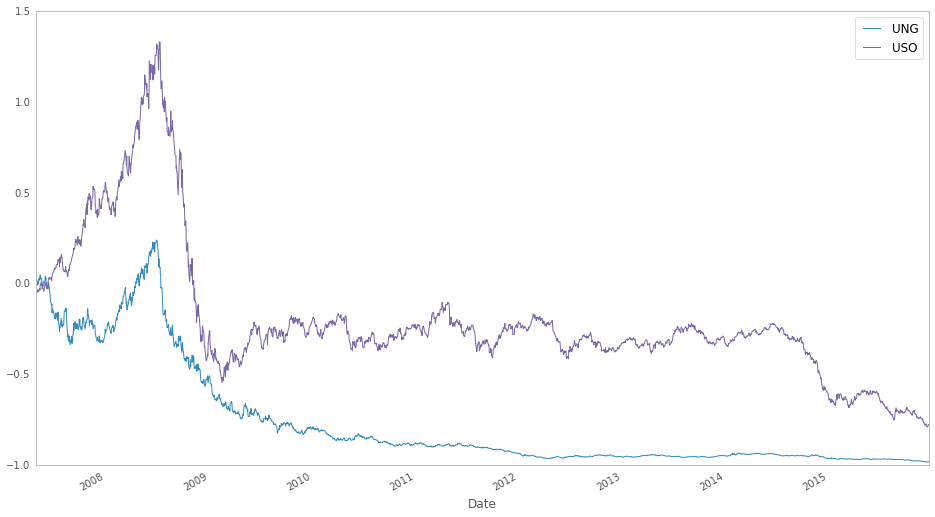

In [275]:
returns.cumret(pd.DataFrame({'USO': x, 'UNG': y}).pct_change()).plot(figsize=(16,9))

In [277]:
x.head()

Date
2007-05-01    50.360001
2007-05-02    49.590000
2007-05-03    49.279999
2007-05-04    48.299999
2007-05-07    48.060001
Name: Adj Close, dtype: float64

In [278]:
def explore(x, y, xname="x", yname="y", model=None):
    print '-' * 80
    print 'Bollinger Band Mean Reversion Strategy: %s vs %s' % (xname, yname)
    print '-' * 80
    print
    print
    fit = strategies.bollinger_mean_revert_fit(x, y, model)
    print 'fit'
    print fit
    print
    results = strategies.bollinger_mean_revert(x, y, fit)
    print returns.report_str(results['returns'], "Returns")
    print strategies.report_str(results['units'], "Trades")
    print 'Score: %.2f' % score_strategy(results)
    print
    print
    return results

--------------------------------------------------------------------------------
Bollinger Band Mean Reversion Strategy: USO vs UNG
--------------------------------------------------------------------------------


   lookback    sharpe
0         5  0.065982
1        10 -0.422698
2        15 -0.100830
3        20  0.226443
4        25  0.591409
5        30  0.407491
   hedge_lookback    sharpe
0               5 -0.334978
1              10 -0.162287
2              15  0.202526
3              20  0.365625
4              25  0.591409
5              50  0.461704
6             100 -0.401557
7             150  0.185244
8             250  0.169747
   entry_z_score    sharpe
0            0.0  0.497767
1            0.5  0.348278
2            1.0  0.591409
3            1.5  0.523281
4            2.0  1.154531
   exit_z_score    sharpe
0           0.0  1.154531
1           0.5  0.828166
2           1.0  0.429666
fit
{'hedge_lookback': 25, 'debug': True, 'exit_z_score': 0.0, 'lookback': 25, 'entry

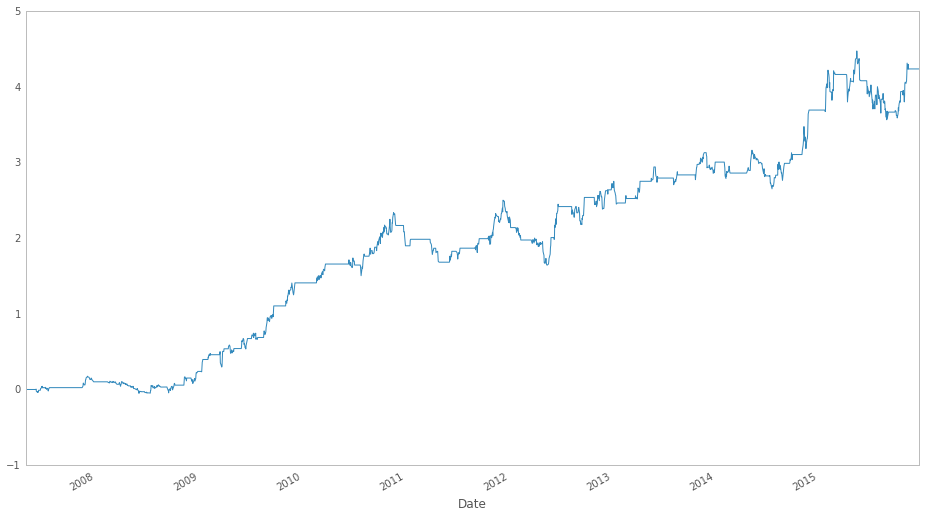

In [279]:
model = {
    'debug': True,
    'lookback': None,
    'hedge_lookback': None,
    'entry_z_score': 'optimize',
    'exit_z_score': 'optimize',
    'static_hedges': False
}

results = explore(x, y, xname=xname, yname=yname, model=model)
returns.cumret(results['returns']).plot(figsize=(16,9))

In [300]:
def static_hedge_portfolio(x, y):
    # Get static hedge ratio (warning, lookahead bias here)
    static_hr = hr.hedge_ratio(x, y, method="tls")
    return y - static_hr * x
    
def static_cadf(x, y):
    return mr.cadf(x, y, method="tls")[0]

def static_halflife(x, y):    
    return mr.halflife(static_hedge_portfolio(x, y))

def pad_left(s, amount, char=' '):
    return char * (amount - len(s)) + s

def pad_right(s, amount, char=' '):
    return s + char * (amount - len(s))

In [302]:
print pad_right('hi', 30) + 'there'
print pad_right('great, sounds good', 30) + 'i think'

hi                            there
great, sounds good            i think


In [359]:
from util import update_with_prefix

universe = pd.DataFrame({'x': x, 'y': y})
start_year = 2008
end_year = 2015
training_years = 3

model = {
    'lookback': 25, #None
    'hedge_lookback': 25, #None
    'entry_z_score': 'optimize',
    'exit_z_score': 'optimize',
    'static_hedges': False,
    'debug': True
}

def update_with_results(dict1, results, prefix):
    bollinger_model_keys = ['cadf', 'hurst', 'halflife', 'theoretical_sharpe', 'annual_sharpe']
    update_with_prefix(dict1, results, prefix, keys=bollinger_model_keys)
    update_with_prefix(dict1, returns.report(results['returns']), prefix)
    update_with_prefix(dict1, strategies.report(results['units']), prefix)

all_results = []
for year in range(start_year, end_year - training_years + 1):
    results = {}
    
    # Add some metadata about the training and test sets
    results['train_years_begin'] = year
    results['train_years_end'] = year + training_years - 1
    results['test_year'] = year + training_years
    if year > start_year:
        results['test_back_year'] = year - 1
    
    # define training and test data as dataframes
    year_map = universe.index.map(lambda x: x.year)
    
    # select the current year + training_years years as training set
    train = universe[(year_map >= year) & (year_map < (year + training_years))]
    results['train_size'] = len(train)
    
    # select the following year as the test set (lookahead)
    test = universe[year_map == year + training_years]
    results['test_size'] = len(test)
    
    # select the prior year (if available) as a second test set
    test_back = None
    if year > start_year:
        test_back = universe[year_map == year - 1]
        results['test_back_size'] = len(test_back)

    # collect static results on the training data
    results['static_cadf'] = static_cadf(train.x, train.y)
    results['static_halflife'] = static_halflife(train.x, train.y)
    
    # fit the model for this strategy
    fit = strategies.bollinger_mean_revert_fit(x, y, model=model, index=train.index)
    results.update(fit)
    
    # collect results of model against the training set
    self_results = strategies.bollinger_mean_revert(x, y, model=fit, index=train.index)
    update_with_results(results, self_results, 'train_')
    
    # collect results of model against the test set
    test_results = strategies.bollinger_mean_revert(x, y, model=fit, index=test.index)
    update_with_results(results, test_results, 'test_')
    #returns.cumret(test_results['returns']).plot(figsize=(16,9))
    
    # Fetch lookbackward test results
    if test_back is not None:
        test_back_results = strategies.bollinger_mean_revert(x, y, model=fit, index=test_back.index)
        update_with_results(results, test_back_results, 'testback_')
    
    all_results.append(results)
    
    if 'debug' in model and model['debug'] == True:
        print '-' * 40
        print year + training_years
        print '-' * 40
        for k in sorted(results.keys()):
            print pad_right(str(k), 30) + str(results[k])
        print
        print

   entry_z_score    sharpe
0            0.0  0.868553
1            0.5  0.682068
2            1.0  0.998755
3            1.5  1.099328
4            2.0  1.660744
   exit_z_score    sharpe
0           0.0  1.660744
1           0.5  1.347914
2           1.0  0.941654
----------------------------------------
2011
----------------------------------------
debug                         True
entry_z_score                 2.0
exit_z_score                  0.0
hedge_lookback                25
lookback                      25
static_cadf                   -1.76306985806
static_halflife               69.2952561653
static_hedges                 False
test_annual_sharpe            0.740814546844
test_apr                      0.108720243652
test_cadf                     -4.55793413914
test_drawdown                 -0.101450357191
test_halflife                 17.536873698
test_hurst                    0.519994903394
test_periods_in_market        91
test_periods_per_trade        19.3846153846
test_si

In [363]:
pd.DataFrame(all_results)[['train_annual_sharpe', 'test_annual_sharpe']]

,train_annual_sharpe,test_annual_sharpe
0,1.660744,0.740815
1,1.486228,1.246769
2,0.896388,1.127725
3,0.651635,1.292624
4,1.107951,0.106911


In [216]:
universe[5:].head()

,x,y
Date,,
2007-01-10,60.590000,21.787986
2007-01-11,60.630001,21.759166
2007-01-12,62.169998,22.268321
2007-01-16,61.970001,21.759166
2007-01-17,62.639999,21.951300


static cadf: -0.638
static halflife: 168.749
{'hedge_lookback': 20, 'debug': False, 'exit_z_score': 0.0, 'lookback': 20, 'entry_z_score': 1.0, 'static_hedges': False}
cadf: -10.821
hurst: 0.516
halflife: 25.579
theoretical sharpe: 0.810
sharpe: 0.963
458
Test of 458 bars
        Total return: -0.228
        Sharpe ratio: -1.10
        APR: -0.126
        Drawdown: -0.26
        Max Time in Drawdown: 414
    
Test of 458 bars
        Total trades: 159
        Trades per period: 0.35
        Periods per trade: 2.88
        Percent time in market: 0.81
        Bars in market: 373
    


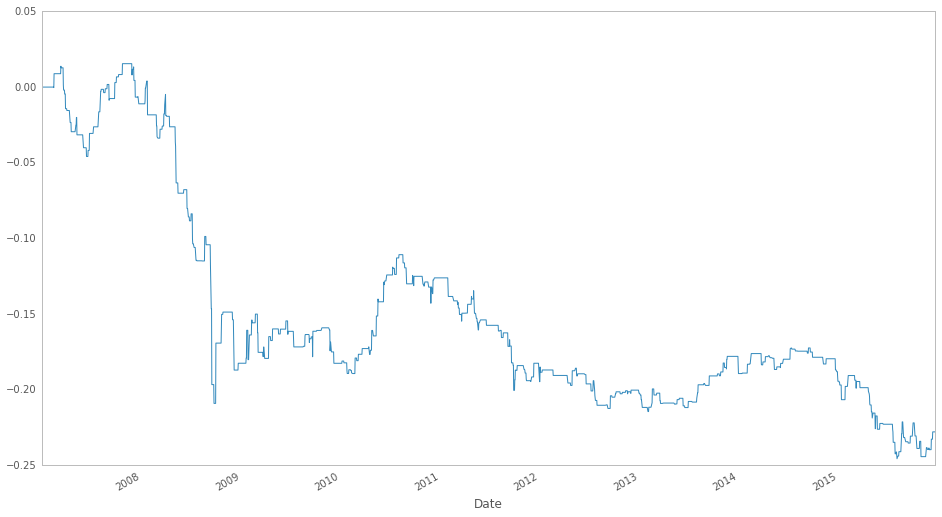

In [265]:
for i in range(1):
    train = universe[np.random.rand(len(universe)) < 0.8]
    test = universe.ix[universe.index.drop(train.index)]

    print 'static cadf: %.3f' % static_cadf(train.x, train.y)
    print 'static halflife: %.3f' % static_halflife(train.x, train.y)
    
    #model = strategies.bollinger_mean_revert_fit(train.x, train.y, model={
    model = strategies.bollinger_mean_revert_fit(x, y, model={
        'lookback': None,
        'hedge_lookback': None,
        'entry_z_score': 'optimize',
        'exit_z_score': 0.0, #'optimize',
        'static_hedges': False,
        'debug': False
    #})
    }, index=train.index)
    print model
    
    #self_results = strategies.bollinger_mean_revert(train.x, train.y, model=model)
    self_results = strategies.bollinger_mean_revert(x, y, model=model, index=train.index)
    print 'cadf: %.3f' % self_results['cadf']
    print 'hurst: %.3f' % self_results['hurst']
    print 'halflife: %.3f' % self_results['halflife']
    print 'theoretical sharpe: %.3f' % self_results['theoretical_sharpe']
    print 'sharpe: %.3f' % self_results['annual_sharpe']
    
    #results = strategies.bollinger_mean_revert(test.x, test.y, model=model)
    print len(test.index)
    results = strategies.bollinger_mean_revert(x, y, model=model, index=test.index)
    rets = results['returns'].copy()
    rets[train.index] = 0
    cumrets = returns.cumret(rets)
    #cumrets[train.index] = 0
    cumrets.plot(figsize=(16,9))
    print returns.report_str(results['returns'][test.index], "Test of %d bars" % len(test.index))
    print strategies.report_str(results['units'][test.index], "Test of %d bars" % len(test.index))